<h1 style='color: yellow'> Metric Generator </h1>

Generates all the ToE metrics

In [2]:
# Standard Library Imports
import os
import sys
from importlib import reload
from functools import partial
from enum import Enum
from typing import NamedTuple
from time import sleep, time
from glob import glob
from pathlib import Path
# Third-Party Library Imports
import numpy as np
from numpy.typing import ArrayLike
import pandas as pd
import xarray as xr
import dask
from scipy.stats import spearmanr
# Plotting imports
import hvplot.xarray
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker as mticker
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import seaborn as sns
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# My imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts'))
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts', 'src'))
import constants
import utils
import plotting_utils
import climate_utils
import stats
import diagnostic_tools
import paths

import time_of_emergence_calc as toe_calc
import time_of_emergence_data_analysis as toe_da
import toe_constants as toe_const
import open_data
from toe_constants import PVALUE_THESHOLD1, OVERLAP_THRESHOLD, SN_THRESHOLD1
import time_of_emergence_plots
import toe_constants as toe_const
import plotting_utils
import misc
# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', message="p-value floored: true value smaller than 0.001")
warnings.filterwarnings('ignore', message="p-value capped: true value larger than 0.25")

Matplotlib created a temporary cache directory at /jobfs/132571481.gadi-pbs/matplotlib-uhmtfb8a because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [3]:
xr.set_options(display_expand_data=False)

In [4]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='numpy.lib.function_base')

In [5]:
# import matplotlib.pylab as pylab
# pylab.rcParams.update({'axes.labelsize':20, 'xtick.labelsize': 16, 'ytick.labelsize': 16, 'figure.figsize': [12, 6]})

In [6]:
# client.close()

In [7]:
from dask.distributed import Client, wait
# # client = Client(threads_per_worker=1, n_workers=20)
# client.close()
client = Client(n_workers=12, threads_per_worker=1, memory_limit=None) 
client

 - State start
 - Found stale lock file and directory '/jobfs/132571481.gadi-pbs/dask-scratch-space/worker-atcg_wpl', purging
 - Found stale lock file and directory '/jobfs/132571481.gadi-pbs/dask-scratch-space/worker-usbjld0m', purging
 - Found stale lock file and directory '/jobfs/132571481.gadi-pbs/dask-scratch-space/worker-4kau6fqf', purging
 - Found stale lock file and directory '/jobfs/132571481.gadi-pbs/dask-scratch-space/worker-rzicdko0', purging
 - Found stale lock file and directory '/jobfs/132571481.gadi-pbs/dask-scratch-space/worker-vjtk_pz_', purging
 - Found stale lock file and directory '/jobfs/132571481.gadi-pbs/dask-scratch-space/worker-nn7fwvv9', purging
 - Found stale lock file and directory '/jobfs/132571481.gadi-pbs/dask-scratch-space/worker-iia863kz', purging
 - Found stale lock file and directory '/jobfs/132571481.gadi-pbs/dask-scratch-space/worker-fnpcb4vl', purging
 - Found stale lock file and directory '/jobfs/132571481.gadi-pbs/dask-scratch-space/worker-yfo53

<Client: 'tcp://127.0.0.1:33377' processes=12 threads=12>

 - Register worker <WorkerState 'tcp://127.0.0.1:46747', name: 13, status: init, memory: 0, processing: 0>
 - Starting worker compute stream, tcp://127.0.0.1:46747
 - Starting established connection to tcp://127.0.0.1:55712
 - Register worker <WorkerState 'tcp://127.0.0.1:37889', name: 12, status: init, memory: 0, processing: 0>
 - Starting worker compute stream, tcp://127.0.0.1:37889
 - Starting established connection to tcp://127.0.0.1:55696
 - Register worker <WorkerState 'tcp://127.0.0.1:39827', name: 15, status: init, memory: 0, processing: 0>
 - Starting worker compute stream, tcp://127.0.0.1:39827
 - Starting established connection to tcp://127.0.0.1:55728
 - Register worker <WorkerState 'tcp://127.0.0.1:35005', name: 17, status: init, memory: 0, processing: 0>
 - Starting worker compute stream, tcp://127.0.0.1:35005
 - Starting established connection to tcp://127.0.0.1:55740
 - Register worker <WorkerState 'tcp://127.0.0.1:40973', name: 19, status: init, memory: 0, processing: 

In [8]:
xr.set_options(display_expand_attrs=False)
xr.set_options(display_expand_data=True)
np.set_printoptions(precision=2, suppress=True, edgeitems=1)

<h1 style='color:yellow'> Opening Data </h1>

In [9]:
print(np.array(toe_const.YearRange))

[<YearRange.MODERN_PERIOD: (1959, 1989)>
 <YearRange.MID_20TH_CENTURY: (1929, 1959)>
 <YearRange.EARLY_20TH_CENTURY: (1899, 1929)>
 <YearRange.ERA5_START: (1940, 1970)>]


In [10]:
# Create a data set for the base period used as the pre-industrial climate 
# base_period = #(1959, 1989)#(1900, 1950)#(1900, 1931)
base_period = toe_const.YearRange.ERA5_START
base_period, base_period.start, base_period.end

(<YearRange.ERA5_START: (1940, 1970)>, 1940, 1970)

<h2 style='color:cyan'> Data Funcions </h2>

In [11]:
reload(open_data)

<module 'open_data' from '/home/563/ab2313/Documents/time_of_emergene_drafts/src/open_data.py'>

In [12]:
# data_ds = open_data.open_best()
# chunks = open_data.best_chunks

# # data_ds = open_data.open_gpcc(resample='QS-DEC')
# # Precip variables must have extra selections
# # data_ds = data_ds.sel(time=data_ds.time.dt.month==12)

In [13]:
# from glob import glob
# var = 'tmax'
# path = f'/g/data/rt52/era5/single-levels/reanalysis/{var}/*/*.nc'
# files_to_open = glob(path, recursive=True)
# print(len(files_to_open))
# td = xr.open_dataset(files_to_open[-30])

In [14]:
# resample = 'QS-JUN'#'QS-DEC' # 'YE'
# chunks = open_data.CHUNKS['access']['small']

# data_ds = open_data.open_access(
#     variable='pr',
#     ensemble='r10i1p1f1',
#     scenario='ssp585',
#     resample=resample
# ).chunk(chunks).isel(time=slice(1, None))

In [15]:
# import paths
# np.array(os.listdir(paths.ERA5_PATH))

In [16]:
# # Potential era5 variables - cape, skt (skin temperature), smlt (snow melt)
# # data_ds = open_data.open_era5('tmax', resample_method='max', save=True).isel(time=slice(None, -1))
# chunks = open_data.ERA5_CHUNKS #ERA5_SMALL_CHUNKS
# data_ds = open_data.open_era5(
#     't2m',
#     return_raw = False,
#     save = True,
#     resample_method = "sum",
#     logginglevel='INFO',
#     chunks = chunks,
# )
# data_ds = data_ds.isel(time=slice(None, -1))
# # data_das = open_data.open_era5_reanalysis('tmax') # Only use this if saving. Otherwise use open_era5

In [17]:
# data_ds

<h2 style='color: cyan'> ERA5 Resample (large data) </h2>

In [18]:
def dask_percentile(array: np.ndarray, axis: str, q: float):
    '''
    Applies np.percetnile in dask across an axis
    Parameters:
    -----------
    array: the data to apply along
    axis: the dimension to be applied along
    q: the percentile
    
    Returns:
    --------
    qth percentile of array along axis
    
    Example
    -------
    xr.Dataset.data.reduce(xca.dask_percentile,dim='time', q=90)
    '''
    return array.map_blocks(
        np.nanpercentile,
        axis=axis,
        q=q,
        dtype=array.dtype,
        drop_axis=axis)

In [19]:
# np.array(os.listdir('/g/data/rt52/era5/single-levels'))
# np.array(os.listdir('/g/data/rt52/era5/single-levels/monthly-averaged'))

In [20]:
client.cluster.scale(100)
sleep(6)

 -         Start Nanny at: 'tcp://127.0.0.1:41859'
 -         Start Nanny at: 'tcp://127.0.0.1:44981'
 -         Start Nanny at: 'tcp://127.0.0.1:33017'
 -         Start Nanny at: 'tcp://127.0.0.1:41031'
 -         Start Nanny at: 'tcp://127.0.0.1:44599'
 -         Start Nanny at: 'tcp://127.0.0.1:41889'
 -         Start Nanny at: 'tcp://127.0.0.1:46567'
 -         Start Nanny at: 'tcp://127.0.0.1:33153'
 -         Start Nanny at: 'tcp://127.0.0.1:40179'
 -         Start Nanny at: 'tcp://127.0.0.1:41735'
 -         Start Nanny at: 'tcp://127.0.0.1:39461'
 -         Start Nanny at: 'tcp://127.0.0.1:38891'
 -         Start Nanny at: 'tcp://127.0.0.1:34859'
 -         Start Nanny at: 'tcp://127.0.0.1:46141'
 -         Start Nanny at: 'tcp://127.0.0.1:33729'
 -         Start Nanny at: 'tcp://127.0.0.1:43041'
 -         Start Nanny at: 'tcp://127.0.0.1:39805'
 -         Start Nanny at: 'tcp://127.0.0.1:35951'
 -         Start Nanny at: 'tcp://127.0.0.1:35957'
 -         Start Nanny at: 'tcp

In [21]:
CHUNKS_FOR_ERA5 = {
    'time': -1,
    'lat': 721//7,
    'lon':1440//12
}

In [22]:
#'2t': 2m tempeature
# 'tp': total precipitation
var = '2t'
var_name = 'tx99count'#'rx1d'#var
base_path = f'/g/data/rt52/era5/single-levels/reanalysis'
path = os.path.join(base_path, var)

In [23]:
MY_ERA5_PATH = os.path.join(paths.DATA_DIR, 'era5')
output_file = Path(os.path.join(MY_ERA5_PATH, f"{var_name}.zarr"))
output_file

PosixPath('/g/data/w40/ab2313/time_of_emergence/era5/tx99count.zarr')

In [24]:
wild_tag = '*/*.nc'
years = np.sort(os.listdir(path))
files_to_open = np.array(glob(os.path.join(path, wild_tag), recursive=True))

In [25]:
files_to_open[:2]

array(['/g/data/rt52/era5/single-levels/reanalysis/2t/1945/2t_era5_oper_sfc_19450601-19450630.nc',
       '/g/data/rt52/era5/single-levels/reanalysis/2t/1945/2t_era5_oper_sfc_19450701-19450731.nc'],
      dtype='<U88')

In [26]:
td = xr.open_dataset(files_to_open[0]).to_array()#[var]
td.attrs

{'Conventions': 'CF-1.6',
 'history': '2023-11-28 00:50:05 UTC+1100 by era5_replication_tools-1.12.0: mv /g/data/rt52/admin/incoming/era5/single-levels/reanalysis/2t/1945/2t_era5_oper_sfc_19450601-19450630.tmp /g/data/rt52/era5/single-levels/reanalysis/2t/1945/2t_era5_oper_sfc_19450601-19450630.nc\n2023-11-28 00:49:26 UTC+1100 by era5_replication_tools-1.12.0: nccopy -ctime/93,latitude/91,longitude/180 -m2G -h2G -k4 -d2 -s /g/data/id28/admin/incoming/era5/single-levels/reanalysis/2t/1945/2t_era5_oper_sfc_19450601-19450630.nc /g/data/rt52/admin/incoming/era5/single-levels/reanalysis/2t/1945/2t_era5_oper_sfc_19450601-19450630.tmp\n2023-11-28 00:45:27 UTC+1100 by era5_replication_tools-1.12.0: curl --connect-timeout 20 --show-error --silent --max-time 36000 -o /g/data/id28/admin/incoming/era5/single-levels/reanalysis/2t/1945/2t_era5_oper_sfc_19450601-19450630.nc https://download-0019.copernicus-climate.eu/cache-compute-0019/cache/data0/adaptor.mars.internal-1701092693.6532366-19466-7-312b

In [27]:
td

<xarray.DataArray (variable: 1, time: 720, latitude: 721, longitude: 1440)> Size: 6GB
array([[[[270.14, ..., 270.14],
         ...,
         [233.88, ..., 233.88]],

        ...,

        [[274.36, ..., 274.36],
         ...,
         [216.87, ..., 216.87]]]])
Coordinates:
  * longitude  (longitude) float32 6kB -180.0 -179.8 -179.5 ... 179.5 179.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 6kB 1945-06-01 ... 1945-06-30T23:00:00
  * variable   (variable) object 8B 't2m'
Attributes: (5)

In [28]:
# climatology_files = np.array([
#     f for f in files_to_open 
#     if (
#         (year := int(f.split('/')[-2])) > base_period.start 
#         and year < base_period.end
#     )
# ])

In [29]:
def __preprocess(ds):
    return ds.to_array().rename({'latitude': 'lat', 'longitude': 'lon'})

In [30]:
output_file_tmp = str(output_file).replace('.zarr', '_tmp.zarr')
output_file_tmp

'/g/data/w40/ab2313/time_of_emergence/era5/tx99count_tmp.zarr'

In [31]:
clim_list = []
for i, year in enumerate(np.arange(base_period.start, base_period.end)):
    print(f'{year}, ', end='')
    year_file = np.sort([f for f in files_to_open if str(year) in f.split('/')[-2]])
    da_raw = xr.open_mfdataset(
        year_file,
        use_cftime=True,
        chunks = CHUNKS_FOR_ERA5,#{'time': -1, 'lon': 1440//240, 'lat':731//103},
        preprocess = __preprocess
    )

    # Annual averagte tempature
    da = da_raw.resample(time="1D").mean()
    
    da = da.squeeze("variable", drop=True)
    da.name = var_name
    clim_list.append(da)

1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 

In [32]:
base_period_ds = xr.concat(clim_list, dim='time').chunk(CHUNKS_FOR_ERA5)

In [33]:
base_period_99p_ds = base_period_ds.reduce(dask_percentile, q=99, dim='time')

In [40]:
base_period_99p_ds = base_period_99p_ds.persist()
wait(base_period_99p_ds)

In [42]:
base_period_99p_ds

<xarray.DataArray 'tx99count' (lat: 721, lon: 1440)> Size: 8MB
array([[274.37, ..., 274.37],
       ...,
       [248.84, ..., 248.84]])
Coordinates:
  * lon      (lon) float32 6kB -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * lat      (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0

In [43]:
da_list = []
for i, year in enumerate(years):
    print(f'{year}, ', end='')
    year_file = np.sort([f for f in files_to_open if year in f.split('/')[-2]])
    da_raw = xr.open_mfdataset(
        year_file,
        use_cftime=True,
        chunks = CHUNKS_FOR_ERA5,#{'time': -1, 'lon': 1440//240, 'lat':731//103},
        preprocess = __preprocess
    )

    # Annual averagte tempature
    # da = da_raw.resample(time='Y').mean().compute()

    # Precipitation
    # daily_resample = da_raw.resample(time="1D").sum()
    # da = daily_resample.resample(time="1Y").max()

    # TX99Count
    daily_mean_da = da_raw.resample(time="1D").mean() # Daily mean tempeature
    da = (daily_mean_da > base_period_99p_ds).resample(time='YE').sum()
    #.groupby("time.year").sum()

    da = da.squeeze("variable", drop=True)
    da.name = var_name
    da_list.append(da)
    
    # # Save to Zarr
    # if i == 0:
    #     # First year: Create the Zarr file
    #     da.to_zarr(output_file_tmp, mode="w", consolidated=True)
    #     print(f"Saved {year} to {output_file}")
    # else:
    #     # Subsequent years: Append to the Zarr file
    #     da.to_zarr(output_file_tmp, mode="a", append_dim="time")
    #     print(f"Appended {year} to {output_file}")

1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024, 

In [44]:
# (daily_mean_da > base_period_99p_ds).resample(time='YE').sum().compute().plot()

In [45]:
# data_ds = (xr.open_zarr(output_file_tmp, use_cftime=True)
#            .to_array()
#            .compute()
#            .chunk(chunks=CHUNKS_FOR_ERA5))

In [46]:
data_ds = xr.concat(da_list, dim='time').chunk(CHUNKS_FOR_ERA5)

In [47]:
# data_ds.isel(time=15).plot()

In [49]:
data_ds

<xarray.DataArray 'tx99count' (time: 85, lat: 721, lon: 1440)> Size: 706MB
dask.array<rechunk-merge, shape=(85, 721, 1440), dtype=float64, chunksize=(85, 103, 120), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 6kB -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * lat      (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time     (time) object 680B 1940-12-31 00:00:00 ... 2024-12-31 00:00:00

In [50]:
data_ds.attrs = {
    "dataset_name": 'era5',
    'variable': var_name,
    **data_ds.attrs,
    'save_chunks' : CHUNKS_FOR_ERA5,
    'info':("tp (total precipitation) reampled to daily"
            "sum then resample to yearly max")
}

In [51]:
# data_ds.name = var_name
# data_ds = data_ds.squeeze('variable', drop=True)

In [ ]:
output_file

In [ ]:
data_ds.to_zarr(output_file, mode='w')

In [266]:
chunks = CHUNKS_FOR_ERA5 #ERA5_SMALL_CHUNKS
data_ds = xr.open_zarr(str(output_file), chunks=CHUNKS_FOR_ERA5)[var_name]

In [267]:
# data_ds = data_ds * 1000 # For precipitation

In [268]:
data_ds

<xarray.DataArray 'rx1d' (time: 85, lat: 721, lon: 1440)> Size: 706MB
dask.array<mul, shape=(85, 721, 1440), dtype=float64, chunksize=(85, 103, 120), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float32 6kB -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * time     (time) datetime64[ns] 680B 1940-12-31 1941-12-31 ... 2024-12-31

In [257]:
# data_ds_raw = xr.open_mfdataset(
#     files_to_open,
#     combine="by_coords",
#     parallel=True,
#     chunks={'time': -1, 'lon': 1440//240, 'lat':731//103} ,
#     use_cftime=True,
# )

# # Rename dimensions and re-chunk for efficiency
# data_ds_raw = data_ds_raw.rename({'latitude': 'lat', 'longitude': 'lon'})

# data_ds_resample = data_ds_raw.to_array().resample(time='YE').mean()

# data_ds_resample = data_ds_resample.compute()

# import paths
# MY_ERA5_PATH = os.path.join(paths.DATA_DIR, 'era5')
# SAVE_NAME = os.path.join(MY_ERA5_PATH, f'{var}.zarr')
# data_ds_resample.to_zarr(SAVE_NAME, mode='w')

<h2 style='color:cyan'> Data Check </h2>

In [269]:
chunks

{'time': -1, 'lat': 103, 'lon': 120}

In [270]:
data_ds

<xarray.DataArray 'rx1d' (time: 85, lat: 721, lon: 1440)> Size: 706MB
dask.array<mul, shape=(85, 721, 1440), dtype=float64, chunksize=(85, 103, 120), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float32 6kB -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * time     (time) datetime64[ns] 680B 1940-12-31 1941-12-31 ... 2024-12-31

In [271]:
assert len(data_ds.chunksizes['time']) == 1

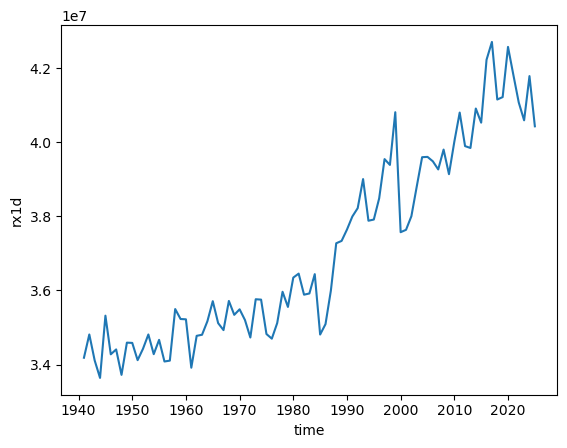

In [272]:
# data_ds.mean(dim=['lat', 'lon']).plot()
data_ds.sum(dim=['lat', 'lon']).plot()

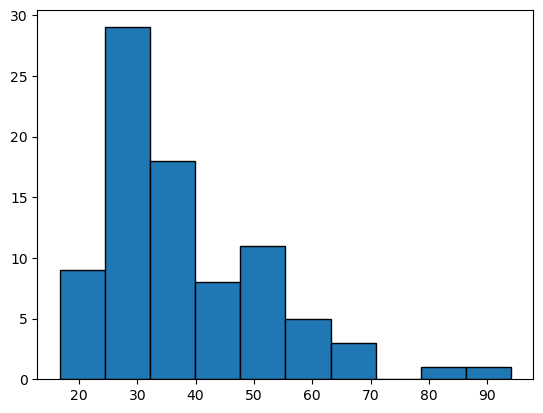

In [273]:
plt.hist(data_ds.sel(lat=-38, lon=145, method='nearest').squeeze().values, edgecolor='k');

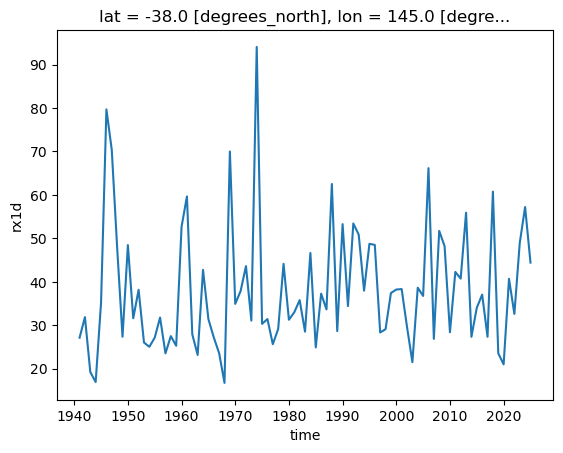

In [274]:
data_ds.sel(lat=-38, lon=145, method='nearest').plot()

In [275]:
t_start = time()

In [278]:
resample_stamp = data_ds.attrs.get('resample', None)
if resample_stamp: resample_stamp = resample_stamp.replace('-', '')
resample_stamp

In [281]:
dataset_name, variable =  'era5',  data_ds.name #data_ds.attrs.dataset_name, data_ds.name #'era5', var_name #
dataset_name, variable

('era5', 'rx1d')

In [282]:
# Specific chunks for era5
# if 'era5' in dataset_name: data_ds = data_ds.compute().chunk(open_data.ERA5_SMALL_CHUNKS)

In [283]:
os.listdir(constants.TOE_SAVE_DIR)

['era5_tp_(1940_1970)',
 'best_temperature_(1959_1989)',
 'best_temperature_(1929_1959)',
 'old',
 'era5_2t_(1959_1989)',
 '.ipynb_checkpoints',
 'era5_2t_(1940_1970)',
 'era5_rx1d_(1940_1970)']

In [284]:
VAR_SAVE_DIR = os.path.join(
    constants.TOE_SAVE_DIR, f'{dataset_name}_{variable}')
                            
if resample_stamp:
    VAR_SAVE_DIR += f'_{resample_stamp}'

VAR_SAVE_DIR += f'_({base_period.start}_{base_period.end})'
VAR_SAVE_DIR

'/g/data/w40/ab2313/time_of_emergence/toe_metrics/era5_rx1d_(1940_1970)'

In [285]:
# os.makedirs(VAR_SAVE_DIR, exist_ok=True)
# I actually do want error if already exists
# os.rmdir(VAR_SAVE_DIR)
os.makedirs(VAR_SAVE_DIR, exist_ok=True)

 - locator: <matplotlib.ticker.AutoLocator object at 0x1538902e8a30>


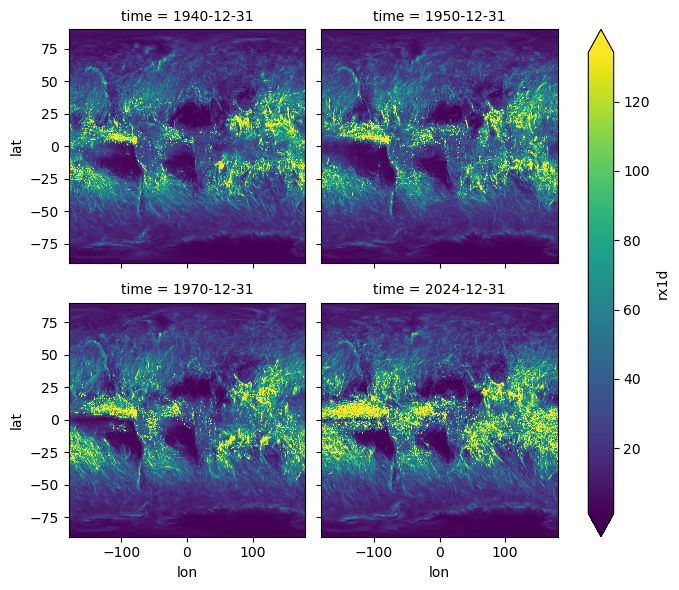

In [286]:
data_ds.isel(time=[0, 10, 30, -1]).plot(col='time', col_wrap=2, robust=True)

In [287]:
len(data_ds.time.values), np.take(data_ds.time.values, [0, 1,2, -3, -2, -1])

(85,
 array(['1940-12-31T00:00:00.000000000', '1941-12-31T00:00:00.000000000',
        '1942-12-31T00:00:00.000000000', '2022-12-31T00:00:00.000000000',
        '2023-12-31T00:00:00.000000000', '2024-12-31T00:00:00.000000000'],
       dtype='datetime64[ns]'))

In [288]:
# Calculate statistics
min_val = data_ds.min().values.item()
q25_val = data_ds.reduce(np.nanpercentile, q=25).values.item()
q75_val = data_ds.reduce(np.nanpercentile, q=75).values.item()
max_val = data_ds.max().values.item()

# Display nicely
print(f"Statistics:\n"
      f"Min: {min_val:.2f}\n"
      f"25th Percentile: {q25_val:.2f}\n"
      f"75th Percentile: {q75_val:.2f}\n"
      f"Max: {max_val:.2f}")


Statistics:
Min: 0.00
25th Percentile: 13.61
75th Percentile: 46.84
Max: 757.07


In [289]:
# Remove data that occurs before this
data_ds = data_ds.sel(time=data_ds.time.dt.year>=base_period.start)
data_ds

<xarray.DataArray 'rx1d' (time: 85, lat: 721, lon: 1440)> Size: 706MB
dask.array<getitem, shape=(85, 721, 1440), dtype=float64, chunksize=(85, 103, 120), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float32 6kB -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * time     (time) datetime64[ns] 680B 1940-12-31 1941-12-31 ... 2024-12-31

 - locator: <matplotlib.ticker.AutoLocator object at 0x1538e0110070>


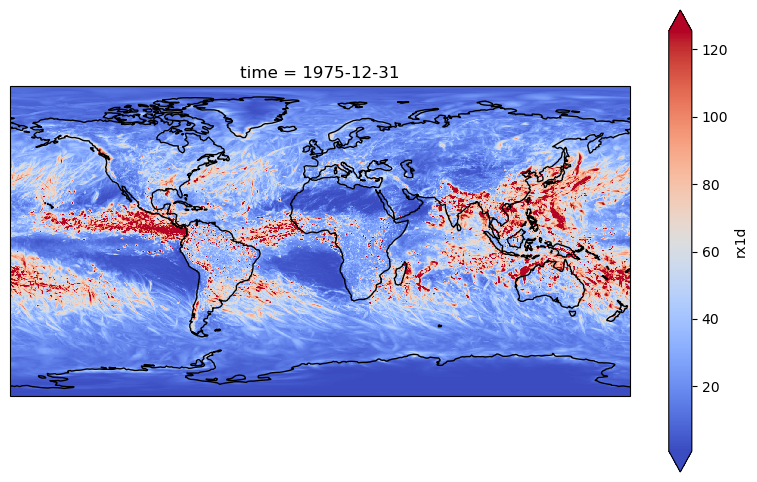

In [290]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
data_ds.isel(time=35).plot(ax=ax,robust=True, cmap='coolwarm')
ax.coastlines()
# ax.set_title('Year 2000')

In [291]:
base_period_ds = data_ds.where(data_ds.time.dt.year.isin(np.arange(*base_period.value)), drop=True)
base_period_ds

<xarray.DataArray 'rx1d' (time: 30, lat: 721, lon: 1440)> Size: 249MB
dask.array<where, shape=(30, 721, 1440), dtype=float64, chunksize=(30, 103, 120), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float32 6kB -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * time     (time) datetime64[ns] 240B 1940-12-31 1941-12-31 ... 1969-12-31

 - locator: <matplotlib.ticker.AutoLocator object at 0x1538b8f51c00>


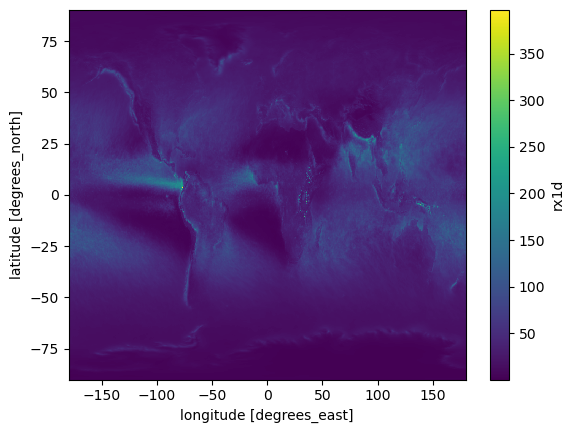

In [292]:
base_period_ds.mean(dim='time').plot()

In [293]:
# Create a mask that removes any grid celss where there are less than 40 point in the base period
base_period_ds_count = base_period_ds.count(dim='time')
# How many years are needed for 80 percent
percent_80_of_years = 0.8*(base_period.end - base_period.start)
data_availability_mask = xr.where(base_period_ds_count>=percent_80_of_years, 1, 0)
data_availability_mask

<xarray.DataArray 'rx1d' (lat: 721, lon: 1440)> Size: 8MB
dask.array<where, shape=(721, 1440), dtype=int64, chunksize=(103, 120), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float32 6kB -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8

 - locator: <matplotlib.ticker.AutoLocator object at 0x1538d8819210>


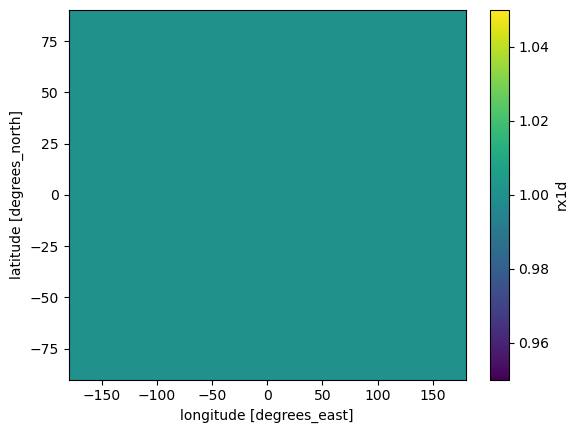

In [294]:
data_availability_mask.plot()

In [295]:
# Apply the mask to both the base period and the full dataset
data_ds = data_ds.where(data_availability_mask)
base_period_ds = base_period_ds.where(data_availability_mask)

In [296]:
# Resetting the anomlies to 1850
data_ds = data_ds - base_period_ds.mean(dim='time')
base_period_ds = base_period_ds - base_period_ds.mean(dim='time')

 - locator: <matplotlib.ticker.AutoLocator object at 0x153892142a70>


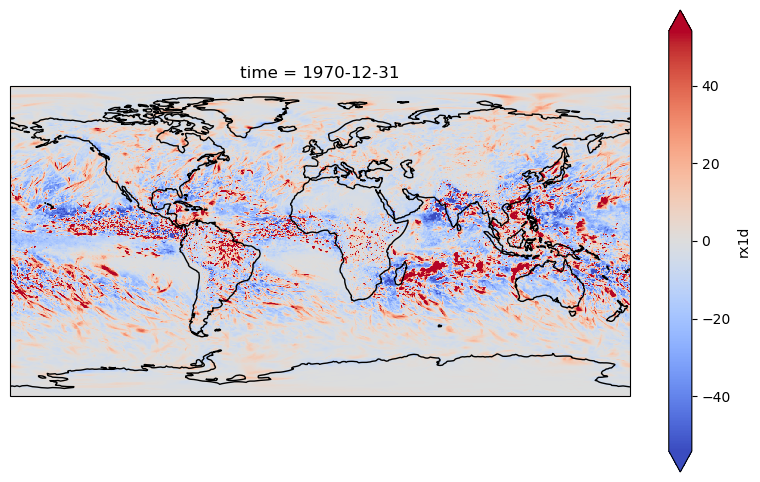

In [297]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection=ccrs.PlateCarree())
data_ds.isel(time=30).plot(ax=ax,robust=True, cmap='coolwarm')
ax.coastlines()
# ax.set_title('Year 2000')

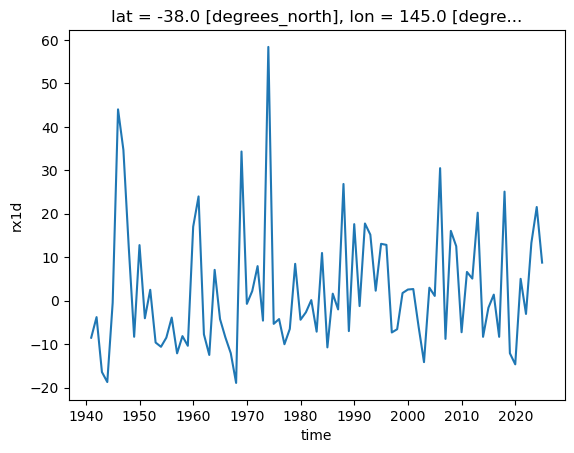

In [298]:
data_ds.sel(lat=-38, lon=145, method='nearest').plot()

In [299]:
data_ds

<xarray.DataArray 'rx1d' (time: 85, lat: 721, lon: 1440)> Size: 706MB
dask.array<sub, shape=(85, 721, 1440), dtype=float64, chunksize=(85, 103, 120), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float32 6kB -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * time     (time) datetime64[ns] 680B 1940-12-31 1941-12-31 ... 2024-12-31

<h1 style='color: yellow'> Metric Calculation </h1>

<h2 style='color: cyan'>Dataset set-up </h2>

<ul>
    <li> Scaling client</li>
    <li> Chunking data set</li>
</ul>

In [300]:
# CHUNKS_FOR_PVALUE_TESTS =  {'lat':30, 'lon':30, 'time':-1}
# CHUNKS_FOR_PVALUE_TESTS = {**chunks, **{'window_dim':-1}}
# CHUNKS_FOR_PVALUE_TESTS =  {'lat':60, 'lon':30, 'time':-1}
# CHUNKS_FOR_PVALUE_TESTS =  {'lat':60, 'lon':30, 'time':-1}

In [301]:
# # Creting new datasets that has windown dimnsion for the rolling calculation
# data_ds_window = (
#     data_ds
#   .persist()
#   .rolling(time=window, center=True, min_periods=window)
#   .construct('window_dim')
#   .persist()
#   .chunk(CHUNKS_FOR_PVALUE_TESTS)
# )

# base_period_window_ds = (
#     base_period_ds
#     .rename({'time':'window_dim'})
#     .persist()
#     .chunk(
#         **{key: CHUNKS_FOR_PVALUE_TESTS[key] for key in ['lat', 'lon', 'window_dim']
#            if key in CHUNKS_FOR_PVALUE_TESTS})
# ) 

In [302]:
# CHUNKS_FOR_PVALUE_TESTS = chunks.copy()
# CHUNKS_FOR_PVALUE_TESTS['lon'] = chunks['lon']/2# * 2
# CHUNKS_FOR_PVALUE_TESTS

In [303]:
window = 30

In [304]:
CHUNKS_FOR_PVALUE_TESTS = CHUNKS_FOR_ERA5
#{
#     'time': -1,
#     'lat': 721//7,
#     'lon':1440//24
# }

# CHUNKS_FOR_PVALUE_TESTS

In [305]:
data_ds_window = (data_ds
                  # .chunk({'window_dim':-1,**CHUNKS_FOR_PVALUE_TESTS})
                  .rolling(time=window, center=True, min_periods=window)
                  .construct('window_dim')
                  .chunk({'window_dim':-1,**CHUNKS_FOR_PVALUE_TESTS})
                  .persist()
                 ) 

base_period_window_ds = (base_period_ds
                         .chunk(CHUNKS_FOR_PVALUE_TESTS)
                         .rename({'time':'window_dim'})
                         .persist()
                        )

In [306]:
wait(data_ds_window);
wait(base_period_window_ds);

In [307]:
data_ds_window

<xarray.DataArray 'rx1d' (time: 85, lat: 721, lon: 1440, window_dim: 30)> Size: 21GB
dask.array<rechunk-merge, shape=(85, 721, 1440, 30), dtype=float64, chunksize=(85, 103, 120, 30), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float32 6kB -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8
  * time     (time) datetime64[ns] 680B 1940-12-31 1941-12-31 ... 2024-12-31
Dimensions without coordinates: window_dim

In [308]:
data_ds_window.chunks

((85,),
 (103, 103, 103, 103, 103, 103, 103),
 (120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120),
 (30,))

In [309]:
base_period_window_ds

<xarray.DataArray 'rx1d' (window_dim: 30, lat: 721, lon: 1440)> Size: 249MB
dask.array<sub, shape=(30, 721, 1440), dtype=float64, chunksize=(30, 103, 120), chunktype=numpy.ndarray>
Coordinates:
  * lat         (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon         (lon) float32 6kB -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * window_dim  (window_dim) datetime64[ns] 240B 1940-12-31 ... 1969-12-31

In [310]:
# The arguements needed for all of the calculations
rolling_window_kwargs = dict(
    input_core_dims=[['window_dim'], ['window_dim']],
    exclude_dims={'window_dim'},
    vectorize=True,
    dask='parallelized')

In [311]:
# # # P-value methods works better with a large cluster.
# # # Small chunks with large computation
# client.cluster.scale(100);
# sleep(7);

<h2 style='color: cyan'> Overlap Methods </h2>

In [312]:
kde_kwargs= dict(bw_method=0.2) # silverman, scott#bw_method=0.2)

# Optimized

### Perkins

In [313]:
data_arr = data_ds.values.flatten()
data_arr = data_arr[data_arr != 0]

In [314]:
bins = toe_calc.calculate_freedman_diaconis_bins(data_arr, length=len(data_ds.time.values),
                                                logginglevel='DEBUG')

np.unique(np.diff(bins).round(6)).item(), bins

p75=4.811536761348757, p25=-5.172637871560592, iqr=9.984174632909347, length=85
 - 4.541533503620405


(4.541534,
 array([-213.73, -209.19, -204.65, -200.11, -195.56, -191.02, -186.48,
        -181.94, -177.4 , -172.86, -168.32, -163.77, -159.23, -154.69,
        -150.15, -145.61, -141.07, -136.52, -131.98, -127.44, -122.9 ,
        -118.36, -113.82, -109.28, -104.73, -100.19,  -95.65,  -91.11,
         -86.57,  -82.03,  -77.48,  -72.94,  -68.4 ,  -63.86,  -59.32,
         -54.78,  -50.24,  -45.69,  -41.15,  -36.61,  -32.07,  -27.53,
         -22.99,  -18.44,  -13.9 ,   -9.36,   -4.82,   -0.28,    4.26,
           8.8 ,   13.35,   17.89,   22.43,   26.97,   31.51,   36.05,
          40.6 ,   45.14,   49.68,   54.22,   58.76,   63.3 ,   67.84,
          72.39,   76.93,   81.47,   86.01,   90.55,   95.09,   99.64,
         104.18,  108.72,  113.26,  117.8 ,  122.34,  126.88,  131.43,
         135.97,  140.51,  145.05,  149.59,  154.13,  158.68,  163.22,
         167.76,  172.3 ,  176.84,  181.38,  185.92,  190.47,  195.01,
         199.55,  204.09,  208.63,  213.17,  217.72,  222.26,  226

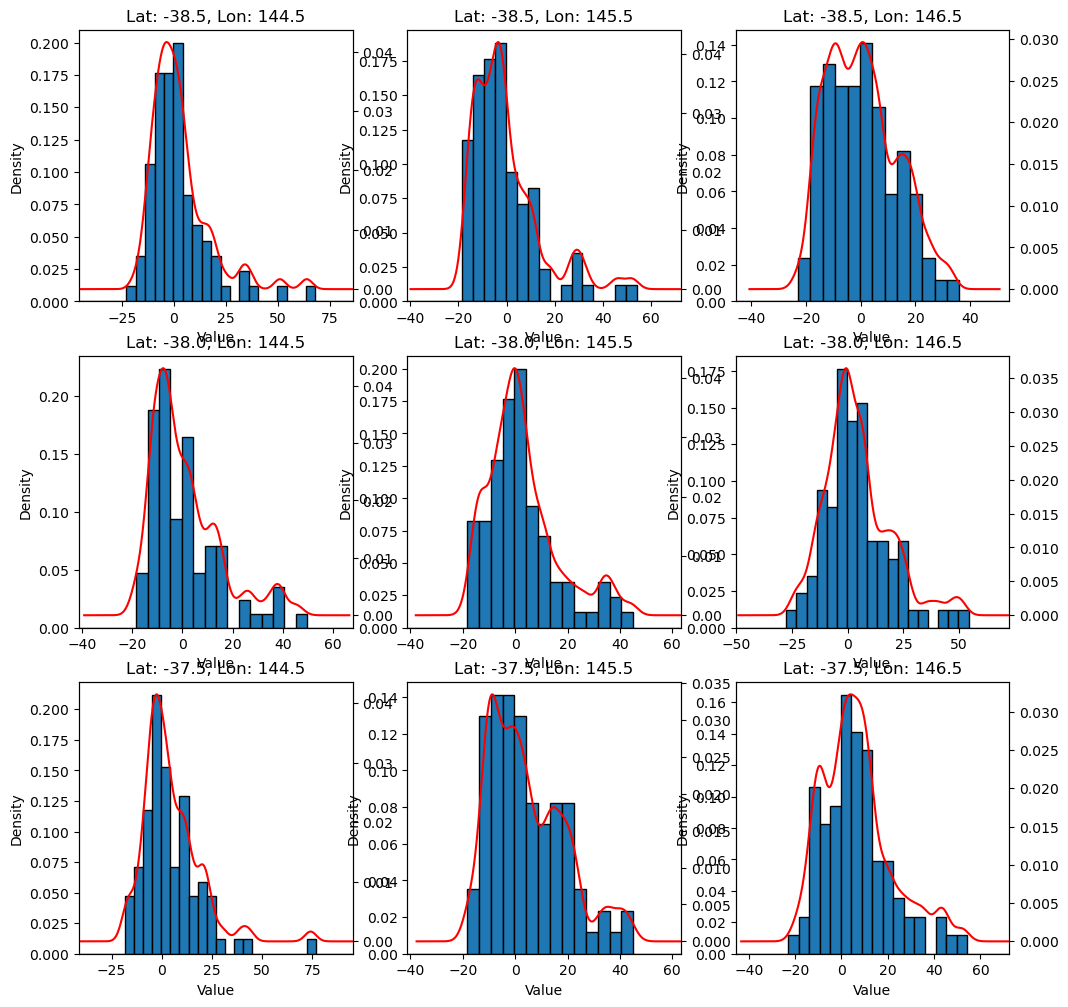

In [315]:
# Example latitudes and longitudes range (adjust as needed)
lats = np.linspace(-38.5, -37.5, 3)  # Replace with your actual latitudes
lons = np.linspace(144.5, 146.5, 3)  # Replace with your actual longitudes

# Create a 3x3 plot grid
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

# Loop through latitudes and longitudes
for i, lat in enumerate(lats):
    for j, lon in enumerate(lons):
        # Extract the data for the current lat, lon
        test_data = data_ds.sel(lat=lat, lon=lon, method='nearest').values
        
        # Compute the KDE
        _, rel_freq = toe_calc.discrete_pdf(test_data, bins=bins)
        x_test, kde_test = toe_calc.create_kde(test_data, **kde_kwargs)

        # Plot on the current subplot
        ax = axs[i, j]
        ax2 = ax.twinx()
        ax.bar(bins[:-1], rel_freq, width=np.diff(bins), align='edge', edgecolor='k')
        ax2.plot(x_test, kde_test, color='r')
        ax.set_title(f'Lat: {lat}, Lon: {lon}')
        ax.set_xlabel('Value')
        ax.set_ylabel('Density')
        valid_bins = bins[:-1][rel_freq > 0]
        x_min, x_max = valid_bins.min()-5*np.diff(bins)[0], valid_bins.max()+5*np.diff(bins)[0]
        ax.set_xlim(x_min, x_max)

In [316]:
%%time
# Pre-calculate the relative frequency of the base period

base_period_rel_freq_ds = xr.apply_ufunc(
    toe_calc.get_rel_freq,
    base_period_ds,
    input_core_dims=[['time']],
    output_core_dims=[['bins']],
    kwargs={'bins': bins},
    vectorize=True,
    dask='parallelized',
    output_sizes={'bins': len(bins) - 1}, 
    output_dtypes=float
).persist()
wait(base_period_rel_freq_ds)

CPU times: user 1.55 s, sys: 418 ms, total: 1.97 s
Wall time: 2.31 s


DoneAndNotDoneFutures(done={<Future: finished, type: numpy.ndarray, key: ('transpose-ef710eb52be5ff976b6485ac79a38a96', 4, 5, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-ef710eb52be5ff976b6485ac79a38a96', 4, 10, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-ef710eb52be5ff976b6485ac79a38a96', 5, 9, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-ef710eb52be5ff976b6485ac79a38a96', 2, 4, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-ef710eb52be5ff976b6485ac79a38a96', 4, 6, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-ef710eb52be5ff976b6485ac79a38a96', 1, 6, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-ef710eb52be5ff976b6485ac79a38a96', 4, 2, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-ef710eb52be5ff976b6485ac79a38a96', 6, 8, 0)>, <Future: finished, type: numpy.ndarray, key: ('transpose-ef710eb52be5ff976b6485ac79a38a96', 3, 5, 0)>, <Future: finished, type: numpy.ndarray, key:

In [317]:
%%time
perkins_ds = xr.apply_ufunc(
    toe_calc.perkins_skill_score_base_bins,
    data_ds_window,
    base_period_rel_freq_ds,
    kwargs={'bins': bins},
    input_core_dims=[['window_dim'], ['bins']],
    exclude_dims={'window_dim'},
    vectorize=True,
    dask='parallelized',
    output_dtypes=float
    ).compute()

CPU times: user 19.8 s, sys: 9.21 s, total: 29 s
Wall time: 45.9 s


In [318]:
perkins_ds = perkins_ds.sortby('lat')

In [319]:
perkins_ds.attrs = {
    'window': window,
    **perkins_ds.attrs,
    'bins': 
    {
        'start':bins.round(4)[0],
        'stop':bins.round(4)[-1],
        'step': np.unique(np.diff(bins)).round(4)[0]}
}

In [320]:
location = dict(lat=69, lon=-165, method='nearest')

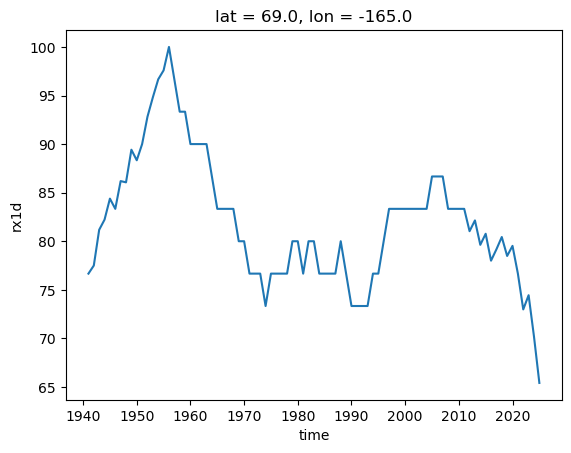

In [321]:
perkins_ds.sel(**location).plot()

In [322]:
base_arr = base_period_ds.sel(**location).values
rel_freq_base = toe_calc.rel_freq(base_arr, bins)
future_arr = data_ds.sel(**location).where(
    data_ds.time.dt.year.isin(np.arange(base_period.start, base_period.start+window)), drop=True).values
rel_freq_future = toe_calc.rel_freq(future_arr, bins=bins)

In [323]:
toe_calc.discrete_distribution_overlap(rel_freq_base, rel_freq_future),\
toe_calc.perkins_skill_score(future_arr, base_arr, bins=bins),\
perkins_ds.sel(**location).isel(time=10).values.item()

(100.0, 100.0, 89.99999999999999)

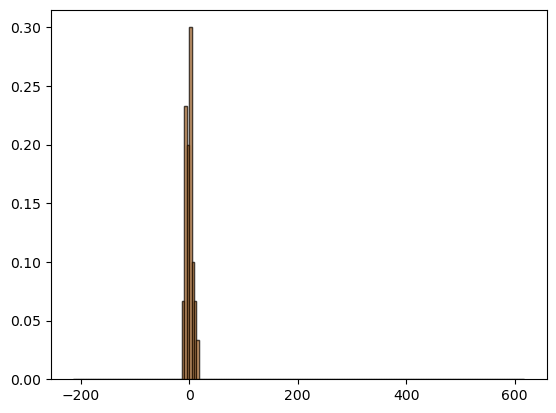

In [324]:
fig, ax = plt.subplots(1, 1)
diagnostic_tools.plot_bar(bins, rel_freq_base, ax=ax)
diagnostic_tools.plot_bar(bins, rel_freq_future, ax=ax)

In [325]:
toe_calc.perkins_skill_score_base_bins(
    data_ds_window.sel(lat=-39, lon=145,method='nearest').isel(time=slice(None, 30)).values,
    base_period_rel_freq_ds.sel(lat=-39, lon=145,method='nearest').values,
    bins=bins
)

92.94871794871796

<BarContainer object of 183 artists>

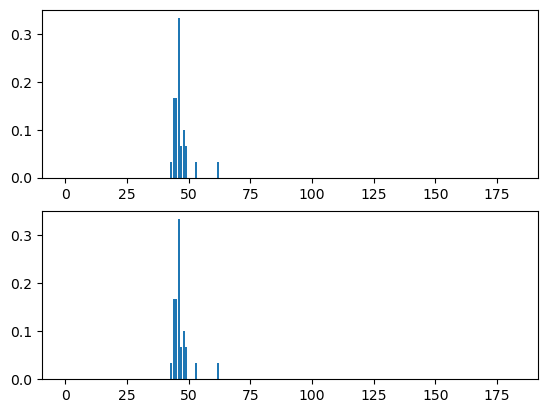

In [326]:
fig, (ax1, ax2) = plt.subplots(2, 1)

test_loc = dict(lat=-39, lon=145, method='nearest')
rel_freq_test = toe_calc.get_rel_freq(base_period_ds.sel(**test_loc).squeeze().values, bins=bins)

ax1.bar(base_period_rel_freq_ds.bins.values, rel_freq_test)
ax2.bar(base_period_rel_freq_ds.bins.values, base_period_rel_freq_ds.sel(**test_loc).values)

 - locator: <matplotlib.ticker.FixedLocator object at 0x1538bbf03940>


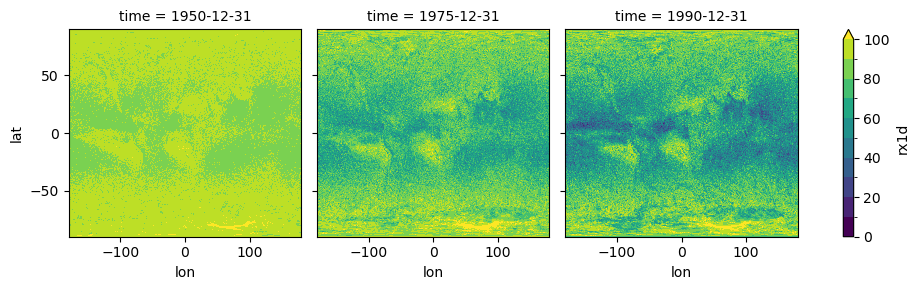

In [327]:
perkins_ds.isel(time=[10, 35, 50]).plot(col='time', levels=np.arange(0, 110, 10))

### KDE Metrics

In [328]:
def create_kde_x_exists(arr: np.ndarray, x: np.ndarray, **kwargs):
    """
    Create a KDE for the given array and evaluate it at the specified points.

    Parameters:
    - arr: np.ndarray, input data for KDE computation.
    - x: np.ndarray, points at which to evaluate the KDE.
    - kwargs: Additional arguments to pass to scipy.stats.gaussian_kde.

    Returns:
    - kde_vals: np.ndarray, normalized KDE values evaluated at `x`.
    """
    # Remove NaN and infinite values from the array
    arr = arr[np.isfinite(arr)]
    
    # Compute the KDE
    kde = toe_calc.gaussian_kde(arr, **kwargs)
    kde_vals = kde(x)

    # Normalize the KDE values to ensure total area equals 1
    kde_vals /= np.trapz(kde_vals, x)

    return kde_vals


In [329]:
def calculate_kde_overlap(dist1, dist2, x):
    """
    Calculate the percentage overlap between two probability density functions (KDEs).
    
    Parameters:
    - dist1: array-like, first KDE values evaluated on x.
    - dist2: array-like, second KDE values evaluated on x.
    - x: array-like, the points where dist1 and dist2 are evaluated.
    
    Returns:
    - overlap_percent: float, percentage overlap between the two distributions.
    """
    # Calculate the overlap shape by taking the minimum of the two KDEs at each point
    overlap_shape = np.minimum(dist1, dist2)
    
    # Integrate the overlap shape to find the overlap area
    overlap_area = np.trapz(overlap_shape, x)
    
    # Convert the overlap area to a percentage (assuming KDEs are normalized)
    overlap_percent = overlap_area * 100

    return overlap_percent


In [330]:
def __overlap_helper_function_base_fitted(
    arr_future: np.ndarray, kde_base: np.ndarray,
    overlap_function, x, method_kwargs=None) -> float:
    """
    Helper function to calculate the overlap between the KDEs of two arrays using a specified overlap function.

    Parameters:
    arr_future (numpy.ndarray): First input array of values.
    arr_base (numpy.ndarray): Second input array of values.
    return_all (bool): If False (default) just return the overlap percent. If True,
                        return the KDEs and the overlap percent.
    kde_kwargs (dict, optional): Keyword arguments to pass to the KDE creation function.
    bmax (float, optional): Maximum value for the range of the KDE.
    bmin (float, optional): Minimum value for the range of the KDE.
    overlap_function (callable, optional): Function to calculate overlap between two distributions.
                                           Should accept `kde_base`, `kde_future`, and `x` as arguments.

    Returns:
    float: Overlap area as calculated by the specified overlap function. Returns NaN if any array is fully NaN.
    """
    if not method_kwargs: method_kwargs = {}

    # Check if any input array is fully NaN
    if np.all(np.isnan(arr_future)): return np.nan

    kde_future = create_kde_x_exists(arr_future, x, **method_kwargs)
    # print(kde_future == kde_base)
    
    out_metric = overlap_function(kde_base, kde_future, x)
    return out_metric

In [331]:
# The x-values for the KDE are based upon the max and min
data_max = data_ds.max().persist().values.item()
data_min = data_ds.min().persist().values.item()
num_points = 1000
x = toe_calc.create_x(bmin=data_min, bmax=data_max, num_points=num_points)

data_min, data_max, x.shape

(-213.7305698115657, 615.8172921485984, (1000,))

In [332]:
%%time
# Pre-calculate the base period KDE

base_period_kde = xr.apply_ufunc(
    create_kde_x_exists,
    base_period_ds,
    input_core_dims=[['time'], ],
    output_core_dims=[['x']],
    kwargs={'x': x, **kde_kwargs},
    vectorize=True,
    dask='parallelized',
    output_sizes={'x':len(x)},  # Specify the size of the 'bin' dimension
    output_dtypes=float
).persist()
wait(base_period_kde);

CPU times: user 3.99 s, sys: 1.39 s, total: 5.38 s
Wall time: 7.55 s


In [333]:
fractional_geometric_area_optimized = partial(
    __overlap_helper_function_base_fitted,
    overlap_function=calculate_kde_overlap)

In [334]:
hellinger_distance_optimized = partial(
    __overlap_helper_function_base_fitted,
    overlap_function=toe_calc.calculate_hellinger_distance)

In [335]:
%%time
hellinger_ds = xr.apply_ufunc(
    hellinger_distance_optimized,
    data_ds_window,
    base_period_kde,
    input_core_dims=[['window_dim'], ['x']],
    exclude_dims={'window_dim'},
    kwargs={'x': x, 'method_kwargs':kde_kwargs},
    vectorize=True,
    dask='parallelized',
    output_dtypes=float
).compute()

CPU times: user 4min 3s, sys: 1min 43s, total: 5min 46s
Wall time: 8min 52s


In [336]:
%%time
frac_geom_ds = xr.apply_ufunc(
    fractional_geometric_area_optimized,
    data_ds_window,
    base_period_kde,
    input_core_dims=[['window_dim'], ['x']],
    exclude_dims={'window_dim'},
    kwargs={'x': x, 'method_kwargs':kde_kwargs},
    vectorize=True,
    dask='parallelized',
    output_dtypes=float
).compute()
# wait(frac_geom_ds2)

CPU times: user 3min 38s, sys: 1min 47s, total: 5min 25s
Wall time: 8min 49s


In [337]:
x_attrs = { 'bmin': data_min, 'bmax':data_max, 'num_points': num_points}
frac_geom_ds.attrs = {'window': window,**frac_geom_ds.attrs, **kde_kwargs, **x_attrs}
hellinger_ds.attrs =  {'window': window, **hellinger_ds.attrs, **kde_kwargs, **x_attrs}

In [338]:
hellinger_ds.attrs

{'window': 30,
 'bw_method': 0.2,
 'bmin': -213.7305698115657,
 'bmax': 615.8172921485984,
 'num_points': 1000}

 - locator: <matplotlib.ticker.FixedLocator object at 0x1538ed64b940>


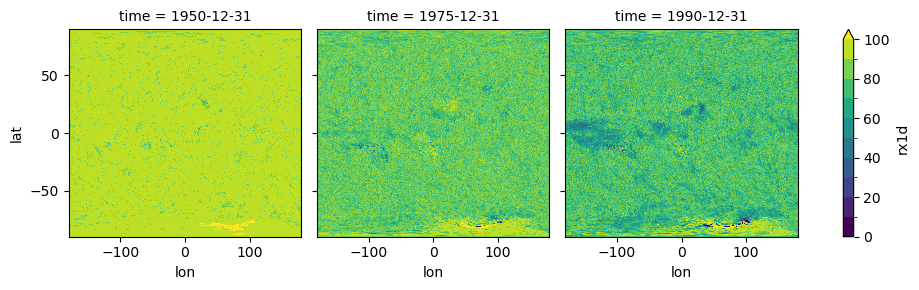

In [339]:
frac_geom_ds.isel(time=[10, 35, 50]).plot(col='time', levels=np.arange(0, 110, 10))

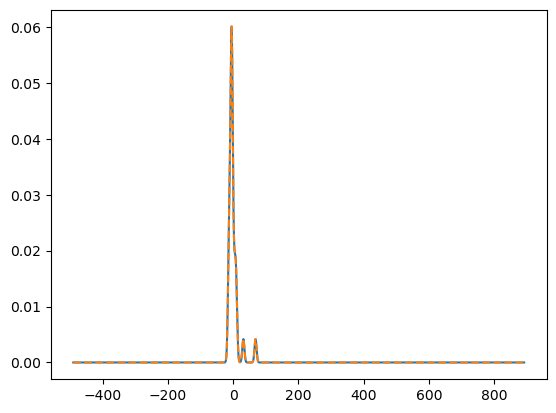

In [340]:
fig, ax1 = plt.subplots(1, 1)

test_loc = dict(lat=-39, lon=145, method='nearest')

test_kde = create_kde_x_exists(base_period_ds.sel(**test_loc).values, x, **kde_kwargs)

ax1.plot(x, base_period_kde.sel(**test_loc).values)
ax1.plot(x, test_kde, linestyle='--')

### Old - Ufunc

In [341]:
# %%time
# perkins_ds = xr.apply_ufunc(
#     toe_calc.perkins_skill_score,
#     data_ds_window,
#     base_period_window_ds,
#     kwargs={'bins': bins},
#     output_dtypes=float,
#     **rolling_window_kwargs
#     ).compute().sortby('lat')

In [342]:
# %%time
# frac_geom_ds = xr.apply_ufunc(
#     toe_calc.fractional_geometric_area,
#     data_ds_window,
#     base_period_window_ds,
#     kwargs = dict(method_kwargs=kde_kwargs),
#     output_dtypes=float,
#     **rolling_window_kwargs
#     ).compute()

In [343]:
# %%time
# hellinger_ds = xr.apply_ufunc(
#     toe_calc.hellinger_distance,
#     data_ds_window,
#     base_period_window_ds,
#     kwargs = dict(method_kwargs=kde_kwargs),
#     output_dtypes=float,
#     **rolling_window_kwargs
#     ).compute()

<h2 style='color: cyan'> P-value Methods </h2>

1d Array Method <br>

This method comapes starting from the begging and looops through. The nans are added to the end so the length matches

In [344]:
# The arguements needed for all of the calculations
rolling_window_kwargs = dict(
    input_core_dims=[['window_dim'], ['window_dim']],
    exclude_dims={'window_dim'},
    vectorize=True,
    dask='parallelized')

In [ ]:
%%time
# Expected: 9 minutes 30 seconds
ttest_ds = xr.apply_ufunc(
        toe_calc.return_ttest_pvalue,
        data_ds_window,
        base_period_window_ds,
    **rolling_window_kwargs
    ).compute()

In [ ]:
%%time
# Expected 3 minutes 30 seconds - best
# 6 23 - era5
ks_ds = xr.apply_ufunc(
        toe_calc.return_ks_pvalue,
        data_ds_window,
        base_period_window_ds,
    **rolling_window_kwargs
    ).compute()

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)
/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/scipy/stats/_axis_nan_policy.py:573: RuntimeWarning: ks_2samp: Exact calculation unsuccessful. Switching to method=asymp.
  res = hypotest_fun_out(*samples, **kwds)


CPU times: user 2min 3s, sys: 1min 1s, total: 3min 4s
Wall time: 5min 37s


In [ ]:
# ks_2samp will perfom on all nan slices
# ks_ds = ks_ds.where(data_availability_mask)

In [ ]:
# %%time
# anderson_ds = xr.apply_ufunc(
#     toe_calc.return_anderson_pvalue,
#     data_ds_window,
#     base_period_window_ds,
#     output_dtypes=float, 
#     **rolling_window_kwargs
#     ).compute()

### Verification of p-value test
- Comparison with 1d rolling func
Verifyting the abstracted (but faster) methods works by comparing to a single lat, lon point.

In [ ]:
lat_lon_sp = dict(lat=-34, lon=145, method='nearest')

In [ ]:
stats_test_1d_array_ks = partial(
    toe_calc.stats_test_1d_array, stats_func=toe_calc.return_ks_pvalue,
    window=window, base_period_length = base_period.end-base_period.start)

In [ ]:
ks_1d_1p = stats_test_1d_array_ks(data_ds.sel(**lat_lon_sp).values)

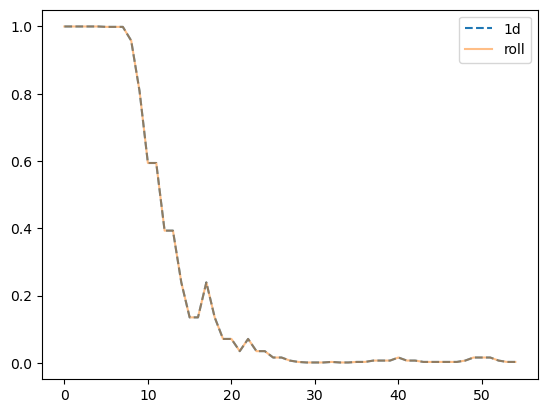

In [ ]:
plt.plot(ks_1d_1p,label='1d', linestyle='--')
plt.plot(ks_ds.sel(**lat_lon_sp).isel(time=slice(int(window/2), -int(window/2))).values, label='roll', alpha=0.5)
plt.legend()

<h2 style='color: cyan'> Signal-to-Noise </h2>

<b> Hawkins S/N Ratio</b>

In [ ]:
# Calculate the wegithed mean
data_ds_smean = climate_utils.weighted_lat_lon_mean(data_ds).compute()

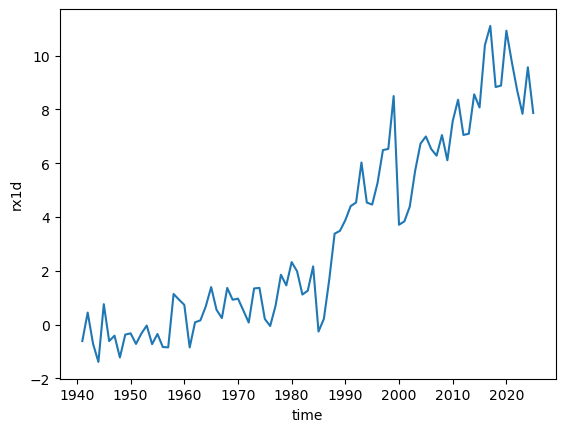

In [ ]:
data_ds_smean.plot()

In [ ]:
# Get lowess filtered version
ds_smean_lowess = stats.trend_fit(data_ds_smean, method='LOWESS', lowess_window=41)

In [ ]:
%%time
return_hawkins_signal_and_noise_partial = partial(toe_calc.return_hawkins_signal_and_noise, 
                                                  gt=ds_smean_lowess.values)

ds_signal_hawkins, ds_noise_series_hawkins = xr.apply_ufunc(
    return_hawkins_signal_and_noise_partial,
    data_ds,
    input_core_dims=[['time']], 
    output_core_dims=[['time'], ['time']], 
    dask='parallelized', 
    vectorize=True,
    output_dtypes=[float, float],
)

ds_signal_hawkins = ds_signal_hawkins.compute()
ds_noise_series_hawkins = ds_noise_series_hawkins.compute()

CPU times: user 3.88 s, sys: 2.02 s, total: 5.9 s
Wall time: 6.32 s


In [ ]:
# Noise 
ds_noise_hawkins_full = ds_noise_series_hawkins.std(dim='time').compute()

ds_noise_hawkins_base_period = ds_noise_series_hawkins.where(
    ds_noise_series_hawkins.time.dt.year.isin(np.arange(*base_period.value)), drop=True).std(dim='time')

# S/N Ratio 
ds_sn_hawkins_full = ds_signal_hawkins/ds_noise_hawkins_full
ds_sn_hawkins_base_period = ds_signal_hawkins/ds_noise_hawkins_base_period

<b> Lowess S/N </b>

In [ ]:
ds_signal_lowess = xr.apply_ufunc(
    stats.apply_lowess, 
    data_ds.chunk({'time':-1, 'lat':10}), 
    input_core_dims=[['time']],
    output_core_dims=[['time']],
    vectorize=True, 
    dask='parallelized',    
).compute()

In [ ]:
# Noise series is detrended data
ds_noise_series_lowess = (data_ds - ds_signal_lowess).compute()
# Noise is std of detrended data
ds_noise_lowess_full = ds_noise_series_lowess.std(dim='time')

ds_noise_lowess_base_period = ds_noise_series_lowess.where(
    ds_noise_series_lowess.time.dt.year.isin(np.arange(*base_period.value)), drop=True).std(dim='time')

# S/N Ratio
ds_sn_lowess_full = ds_signal_lowess/ds_noise_lowess_full
ds_sn_lowess_base_period = ds_signal_lowess/ds_noise_lowess_base_period

### Plot Verificaiton

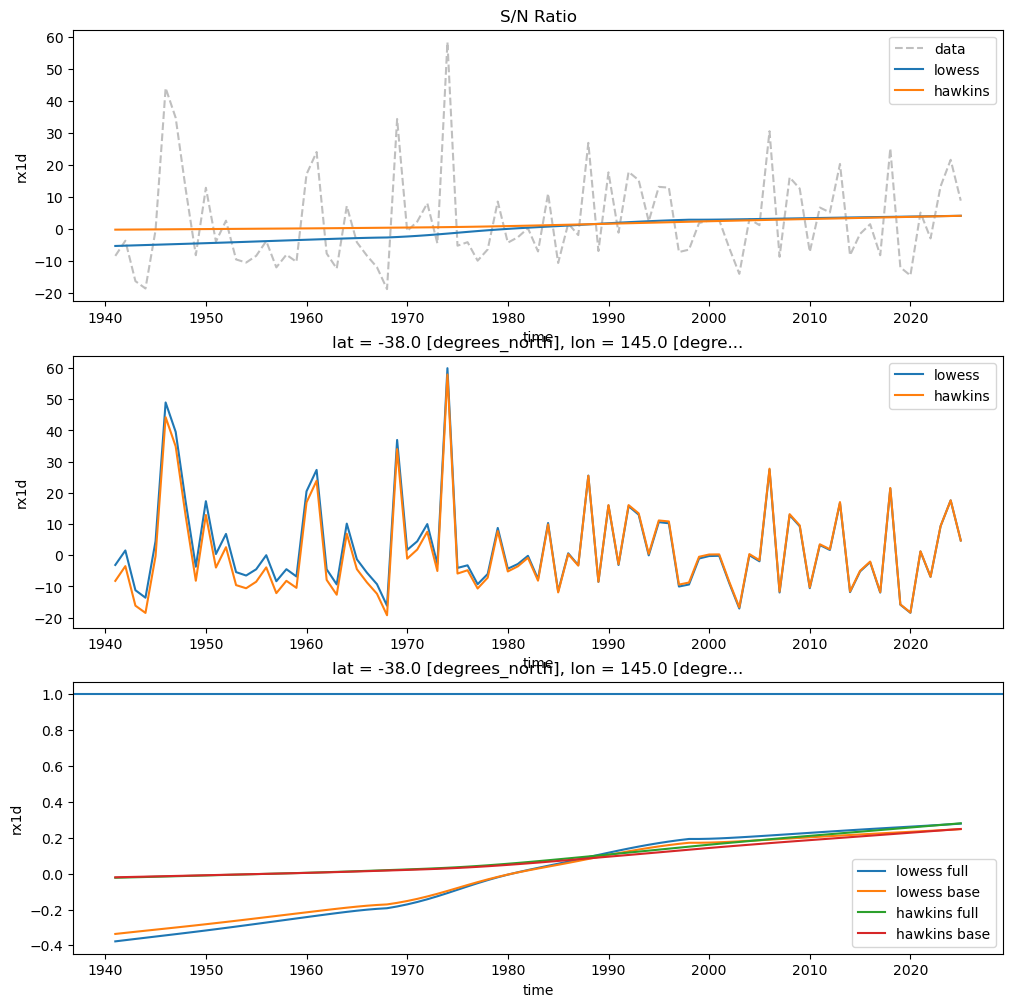

In [ ]:
lat_lon_sp = dict(lat=-38, lon=145, method='nearest')

fig, axes = plt.subplots(3, 1, figsize=(12, 12))

ax1 = axes[0]
data_ds.sel(**lat_lon_sp).plot(label='data', ax=ax1, color='grey', linestyle='--', alpha=0.5)
ds_signal_lowess.sel(**lat_lon_sp).plot(label='lowess', ax=ax1)
ds_signal_hawkins.sel(**lat_lon_sp).plot(label='hawkins', ax=ax1)
ax1.set_title('Signal')
ax1.legend()

ax2= axes[1]
ds_noise_series_lowess.sel(**lat_lon_sp).plot(label='lowess', ax=ax2)
ds_noise_series_hawkins.sel(**lat_lon_sp).plot(label='hawkins', ax=ax2)
ax1.set_title('Noise Series')

ax2.legend()

ax3= axes[2]
ds_sn_lowess_full.sel(**lat_lon_sp).plot(label='lowess full', ax=ax3)
ds_sn_lowess_base_period.sel(**lat_lon_sp).plot(label='lowess base', ax=ax3)

ds_sn_hawkins_full.sel(**lat_lon_sp).plot(label='hawkins full', ax=ax3)
ds_sn_hawkins_base_period.sel(**lat_lon_sp).plot(label='hawkins base', ax=ax3)
ax1.set_title('S/N Ratio')
ax3.axhline(1)
ax3.legend()

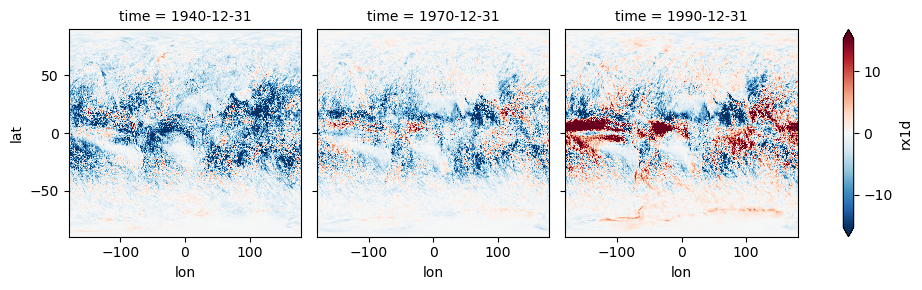

In [ ]:
ds_signal_lowess.isel(time=[0, 30, 50]).plot(col='time', robust=True)

In [ ]:
# Rolling noise variant
# ds_data_noise_lowess_rolling = ds_data_noise_series_lowess.rolling(time=window, min_periods=2).std(dim='time').compute()
# First time step is nan, so remove
# ds_data_noise_lowess_rolling = ds_data_noise_lowess_rolling.isel(time=slice(1, None))
# This is odd. But I am making the fire 19 years (wnindow lenght) have the same noise as the first time the 
# variability can be calculated.
# ds_data_noise_lowess_rolling = xr.concat([
#     ds_data_noise_lowess_rolling.isel(time=slice(0, window-2)).fillna(ds_data_noise_lowess_rolling.isel(time=window-1)),
#     ds_data_noise_lowess_rolling.isel(time=slice(window-1, None))], dim='time')
# ds_data_noise_lowess_rolling = misc.adjust_time_from_rolling(ds_data_noise_lowess_rolling, window)

In [ ]:
# ds_data_noise_lowess_rolling.sel(lat=-40, lon=144, method='nearest')

In [ ]:
# ds_data_sn_lowess_rolling = ds_data_signal_lowess/ds_data_noise_lowess_rolling
# # First time step is nan for noise, so remove
# ds_data_sn_lowess_rolling = ds_data_sn_lowess_rolling.isel(time=slice(1, None))

In [ ]:
# ds_data_noise_lowess_rolling.sel(lat=-38, lon=145, method='nearest').plot()

In [ ]:
# ds_data_sn_lowess

In [ ]:
# client.cluster.scale(6)
# sleep(7)

<h1 style='color: yellow'>  Data Mering and Save </h1>

In [ ]:
ds_signal_lowess.name = 'signal_lowess'
ds_noise_series_lowess.name = 'noise_lowess'
ds_signal_hawkins.name = 'signal_hawkins'
ds_noise_series_hawkins.name = 'noise_hawkins'

In [ ]:
ds_sn_hawkins_full.name = 'sn_hawkins_full'
ds_sn_hawkins_base_period.name = 'sn_hawkins_base'
ds_sn_lowess_full.name = 'sn_lowess_full'
ds_sn_lowess_base_period.name = 'sn_lowess_base'

ks_ds.name = 'ks'
ttest_ds.name = 'ttest'
perkins_ds.name = 'perkins'
frac_geom_ds.name = 'frac'
hellinger_ds.name = 'hd'

In [ ]:
# Set long name attributes for each variable
ds_sn_hawkins_full.attrs['long_name'] = 'S/N Ratio (Hawkins, full)'
ds_sn_hawkins_base_period.attrs['long_name'] = 'S/N Ratio (Hawkins, base)'

ds_sn_lowess_full.attrs['long_name'] = 'S/N Ratio (LOWESS, full)'
ds_sn_lowess_base_period.attrs['long_name'] = 'S/N Ratio (LOWESS, base)'

ttest_ds.attrs['long_name'] = 'T-Test'
ks_ds.attrs['long_name'] = 'Kolmogorov-Smirnov'
perkins_ds.attrs['long_name'] = 'Perkins Skill Score'
frac_geom_ds.attrs['long_name'] = 'Fractional Geometric Area'
hellinger_ds.attrs['long_name'] = 'Hellinger Distance'

In [ ]:
toe_metrics_ds = xr.merge([ks_ds, ttest_ds, perkins_ds, frac_geom_ds, hellinger_ds,
                           ds_sn_hawkins_full,ds_sn_hawkins_base_period,
                          ds_sn_lowess_full, ds_sn_lowess_base_period])

toe_metrics_ds = toe_metrics_ds.isel(time=slice(int(window/2), -int(window/2)))
toe_metrics_ds = toe_metrics_ds.compute()
toe_metrics_ds

<xarray.Dataset> Size: 4GB
Dimensions:          (lat: 721, lon: 1440, time: 55)
Coordinates:
  * lat              (lat) float32 3kB -90.0 -89.75 -89.5 ... 89.5 89.75 90.0
  * lon              (lon) float32 6kB -180.0 -179.8 -179.5 ... 179.5 179.8
  * time             (time) datetime64[ns] 440B 1955-12-31 ... 2009-12-31
Data variables:
    ks               (time, lat, lon) float64 457MB 1.0 1.0 1.0 ... 0.808 0.808
    ttest            (time, lat, lon) float64 457MB 1.0 1.0 ... 0.7233 0.7233
    perkins          (time, lat, lon) float64 457MB 100.0 100.0 ... 86.67 86.67
    frac             (time, lat, lon) float64 457MB 100.0 100.0 ... 77.87 77.87
    hd               (time, lat, lon) float64 457MB 0.0 0.0 0.0 ... 25.04 25.04
    sn_hawkins_full  (lat, lon, time) float64 457MB -0.005127 ... -0.0701
    sn_hawkins_base  (lat, lon, time) float64 457MB -0.005179 ... -0.06038
    sn_lowess_full   (lat, lon, time) float64 457MB -0.2423 -0.2449 ... -0.1262
    sn_lowess_base   (lat, lon, time) float64 457MB -0.2443 -0.2469 ... -0.1091
Attributes: (1)

In [ ]:
dataset_name, variable, base_period

('era5', 'rx1d', <YearRange.ERA5_START: (1940, 1970)>)

In [ ]:
VAR_SAVE_DIR

'/g/data/w40/ab2313/time_of_emergence/toe_metrics/era5_rx1d_(1940_1970)'

In [ ]:
# There is also a lot of processing that has been udnergone for this dataset.
# Worth saving just to keep complete consistency
DATA_SAVE_NAME = os.path.join(VAR_SAVE_DIR, f'data.zarr')
print(DATA_SAVE_NAME)
data_ds.to_zarr(DATA_SAVE_NAME, mode='w')

/g/data/w40/ab2313/time_of_emergence/toe_metrics/era5_rx1d_(1940_1970)/data.zarr


In [ ]:
# THe signal is actually needed for lots of plots
singal_ds = xr.merge([
    ds_signal_lowess,ds_noise_series_lowess ,ds_signal_hawkins , ds_noise_series_hawkins]) 
singal_ds

<xarray.Dataset> Size: 3GB
Dimensions:         (lat: 721, lon: 1440, time: 85)
Coordinates:
  * lat             (lat) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * lon             (lon) float32 6kB -180.0 -179.8 -179.5 ... 179.2 179.5 179.8
  * time            (time) datetime64[ns] 680B 1940-12-31 ... 2024-12-31
Data variables:
    signal_lowess   (lat, lon, time) float64 706MB -0.8299 -0.8104 ... 0.5899
    noise_lowess    (time, lat, lon) float64 706MB 0.9341 0.9341 ... -0.1766
    signal_hawkins  (lat, lon, time) float64 706MB 0.02044 0.01922 ... 0.6927
    noise_hawkins   (lat, lon, time) float64 706MB 0.08378 -1.628 ... -0.2794

In [ ]:
SIGNAL_SAVE_NAME = os.path.join(VAR_SAVE_DIR, f'signal.zarr')
print(SIGNAL_SAVE_NAME)
singal_ds.to_zarr(SIGNAL_SAVE_NAME, mode='w')

/g/data/w40/ab2313/time_of_emergence/toe_metrics/era5_rx1d_(1940_1970)/signal.zarr


In [ ]:
TOE_METRICS_SAVE_NAME = os.path.join(VAR_SAVE_DIR, 'toe_metrics.zarr')
print(TOE_METRICS_SAVE_NAME)
toe_metrics_ds.to_zarr(TOE_METRICS_SAVE_NAME, mode='w')

/g/data/w40/ab2313/time_of_emergence/toe_metrics/era5_rx1d_(1940_1970)/toe_metrics.zarr


In [ ]:
data_availability_mask

<xarray.DataArray 'rx1d' (lat: 721, lon: 1440)> Size: 8MB
dask.array<where, shape=(721, 1440), dtype=int64, chunksize=(103, 120), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 3kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon      (lon) float32 6kB -180.0 -179.8 -179.5 -179.2 ... 179.2 179.5 179.8

In [ ]:
DATA_AVAILABILITY_SAVE_NAME = os.path.join(VAR_SAVE_DIR, 'data_availability_mask.zarr')
print(DATA_AVAILABILITY_SAVE_NAME)
data_availability_mask.to_zarr(DATA_AVAILABILITY_SAVE_NAME, mode='w')

/g/data/w40/ab2313/time_of_emergence/toe_metrics/era5_rx1d_(1940_1970)/data_availability_mask.zarr


In [ ]:
t_end = time()
time_taken = (t_end - t_start)/60
print(f'{time_taken=}minutes')

time_taken=47.464877331256865minutes


Process Dask Worker process (from Nanny):
2025-01-20 15:30:29,533 - distributed.nanny - ERROR - Worker process died unexpectedly
2025-01-20 15:30:29,533 - distributed.nanny - ERROR - Worker process died unexpectedly
2025-01-20 15:30:29,533 - distributed.nanny - ERROR - Worker process died unexpectedly
2025-01-20 15:30:29,533 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
2025-01-20 15:30:29,533 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
Process Dask Worker process (from Nanny):
2025-01-20 15:30:29,534 - distributed.nanny - ERROR - Worker process died unexpectedly
Process Dask Worker process (from Nanny):
Traceback (most recent call last):
  File "/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/nanny.py", line 1019, in _run
    asyncio_run(run(), loop_factory=get_loop_factory())
